# Analysis of InfoGAN latent space

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import torch
from torch.autograd import Variable
import torchvision

from infogan.models import Generator32
from infogan.utils import Code

In [10]:
code = Code(10, 5, 'uniform')
latent_size = 100
z_size = latent_size - code.latent_size

In [11]:
G = Generator32(latent_size, 64, 1)
G.load_state_dict(torch.load('results/saved_data/mnist_InfoGAN_64_generator', map_location=lambda storage, loc: storage))

In [96]:
n_classes = 10
onehot = torch.eye(n_classes).view(n_classes,n_classes)
z = torch.FloatTensor(1,z_size,1,1).normal_()
z = Variable(z)
k = 0
c_dis = onehot[k].view(1,-1)

In [132]:
c_con = code.sample_continuous(1)
c = torch.cat([c_dis, c_con], 1)
c = Variable(c)

In [133]:
img = G(z,c).squeeze()
img.shape

torch.Size([32, 32])

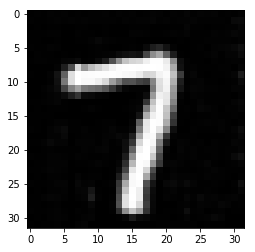

In [134]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(npimg, cmap='gray')

imshow(img.data)